<a href="https://colab.research.google.com/github/24prady02/Prady-repository/blob/main/Ship_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving archive (7).zip to archive (7).zip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

In [ ]:
! mkdir ship_data

In [ ]:
!unzip archive\ \(7\).zip -d ship_data

Archive:  archive (7).zip
  inflating: ship_data/no-ship/no-ship_000000.png  
  inflating: ship_data/no-ship/no-ship_000001.png  
  inflating: ship_data/no-ship/no-ship_000002.png  
  inflating: ship_data/no-ship/no-ship_000003.png  
  inflating: ship_data/no-ship/no-ship_000004.png  
  inflating: ship_data/no-ship/no-ship_000005.png  
  inflating: ship_data/no-ship/no-ship_000006.png  
  inflating: ship_data/no-ship/no-ship_000007.png  
  inflating: ship_data/no-ship/no-ship_000008.png  
  inflating: ship_data/no-ship/no-ship_000009.png  
  inflating: ship_data/no-ship/no-ship_000010.png  
  inflating: ship_data/no-ship/no-ship_000011.png  
  inflating: ship_data/no-ship/no-ship_000012.png  
  inflating: ship_data/no-ship/no-ship_000013.png  
  inflating: ship_data/no-ship/no-ship_000014.png  
  inflating: ship_data/no-ship/no-ship_000015.png  
  inflating: ship_data/no-ship/no-ship_000016.png  
  inflating: ship_data/no-ship/no-ship_000017.png  
  inflating: ship_data/no-ship/no-ship

In [ ]:
datasets=['/content/ship_data']
class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [ ]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass

In [ ]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:00<00:00, 3842.14it/s]


((4000, 48, 48, 3), (4000,))

In [ ]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


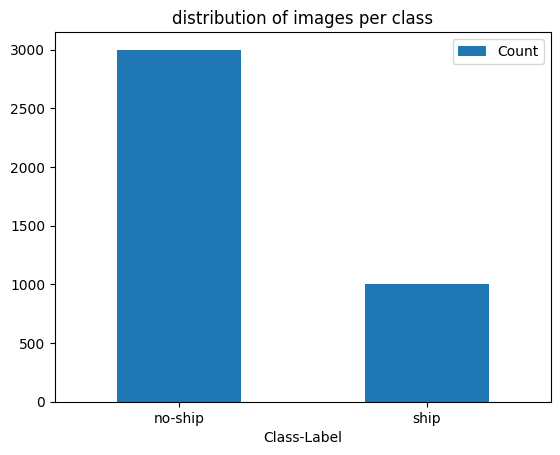

In [ ]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

(-1.0999962084067676,
 1.0999998194479412,
 -1.0999998194479412,
 1.0999962084067674)

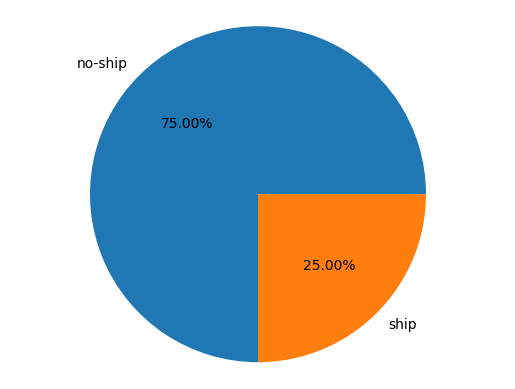

In [ ]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal')

In [ ]:
AUGMENTATION = True

In [ ]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [ ]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:05, 752.48it/s]  


In [ ]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

In [ ]:
labels = to_categorical(labels)

In [ ]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [ ]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

In [ ]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [ ]:
def conv_block(X,k,filters,stage,block,s=2):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)

    return X
    pass

In [ ]:
def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass

In [ ]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [ ]:
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 58, 58, 3)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 29, 29, 16)       64        
 n)                                                              
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNormal  (None, 29, 

In [ ]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [ ]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
256/262 [============================>.] - ETA: 0s - loss: 0.3883 - accuracy: 0.8157
Epoch 1: val_accuracy improved from -inf to 0.87833, saving model to model_weights.h5
262/262 [==============================] - 17s 10ms/step - loss: 0.3861 - accuracy: 0.8175 - val_loss: 0.3111 - val_accuracy: 0.8783
Epoch 2/50
256/262 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9255
Epoch 2: val_accuracy improved from 0.87833 to 0.94917, saving model to model_weights.h5
262/262 [==============================] - 3s 10ms/step - loss: 0.1873 - accuracy: 0.9252 - val_loss: 0.1456 - val_accuracy: 0.9492
Epoch 3/50
260/262 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9460
Epoch 3: val_accuracy improved from 0.94917 to 0.96333, saving model to model_weights.h5
262/262 [==============================] - 2s 7ms/step - loss: 0.1422 - accuracy: 0.9461 - val_loss: 0.1047 - val_accuracy: 0.9633
Epoch 4/50
258/262 [============================>.] 


Epoch 48: val_accuracy did not improve from 0.99000
262/262 [==============================] - 1s 4ms/step - loss: 0.0135 - accuracy: 0.9972 - val_loss: 0.0716 - val_accuracy: 0.9858


In [ ]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 [==============================] - 0s 2ms/step


(1200,)

In [ ]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 [==============================] - 0s 9ms/step


(600,)

In [ ]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()


NameError: ignored

<Figure size 640x480 with 0 Axes>

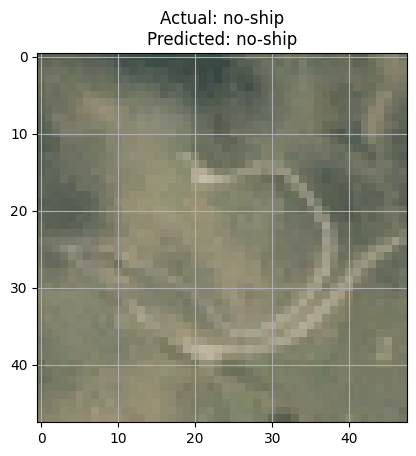

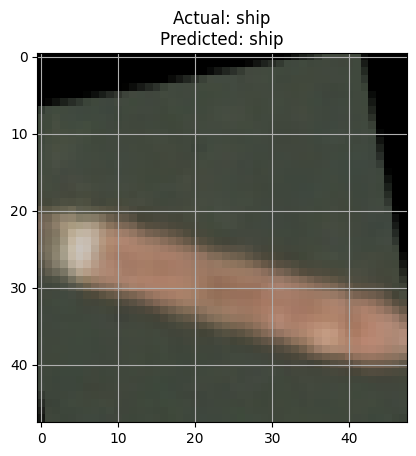

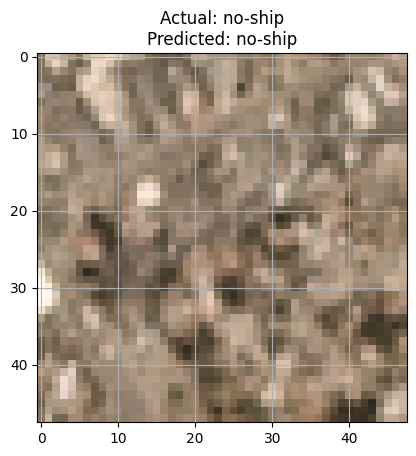

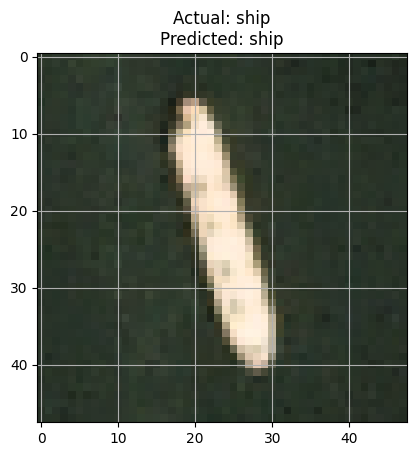

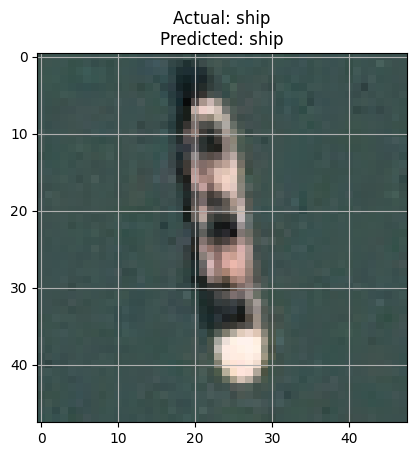

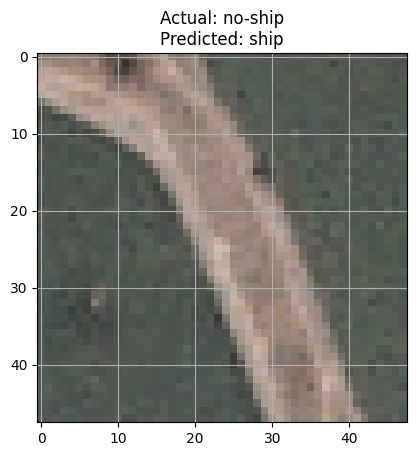

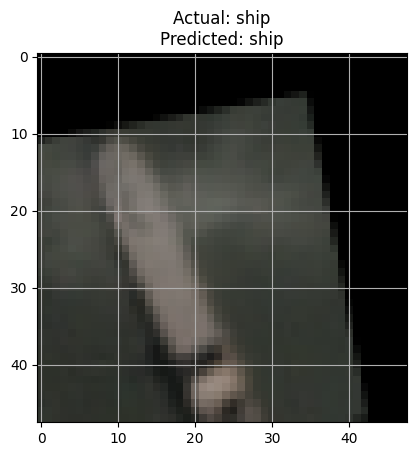

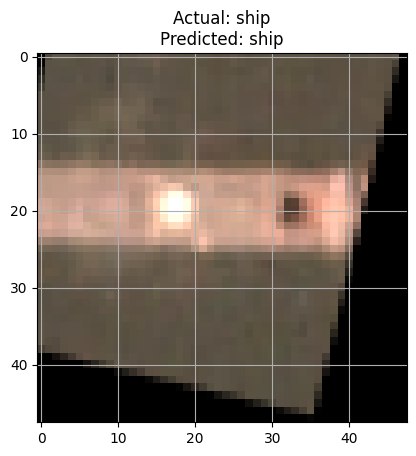

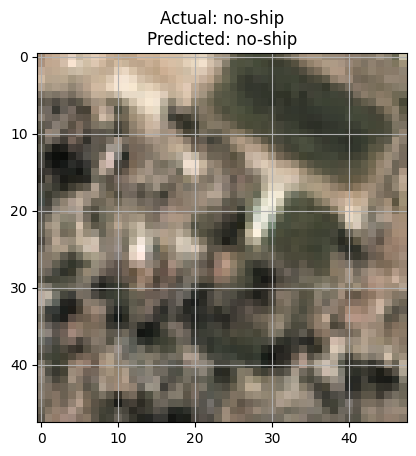

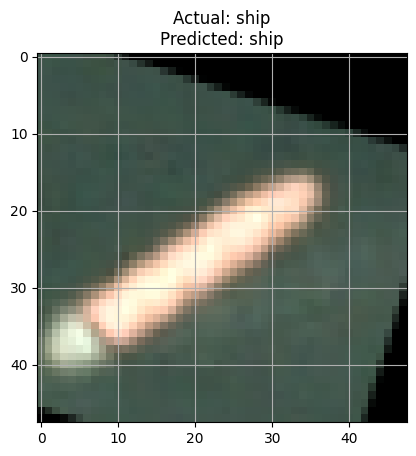

In [ ]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass